# What is Entity Embedding?

There are two mainstream methods to deal with categorical variables in tabular data: [One-hot Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [Label Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

The main disadvantage of the one-hot encoding schems is that it increases the dimensionality of the data set, which brings us the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). And, the resulting data set becomes a lot sparse and this adversely affects many algorithms (eg. distance based).

Lebel Encoding usually a replaces a number to a category. The downside of this approach is that it is not carrying any meaningful information about the ordinance of categories. For instance, if there are three categories in a column by the names of `mouse`, `cat` and `dog`, a label-encoding scheme would replace the categories with `1`, `2` and `3` respectively (say). Even though the category `dog` has assigned a value of three, it doesn't mean that a `dog` is three times larger than a `cat`, which got a value of `1`.

The idea of using entity embeddings is exactly the same as using [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) for a corpus of text. In a word embedding scheme like Word2Vec, a single word gets assigned to a dense vector instead of a sparse vector like in one-hot encoding. Similarly, an entity embedding scheme would map the categories in a cloumn to a set of vectors in a vector space where similar categories live at closer distances and a rich representation in a high dimensional vector space for each category is achieved.

## Steps of building an entity embedding network

Concretely, the steps break down as below:

1. Identify and separate the categorical and numeric columns.
2. Label-encode all the categorical values so that each category is represented by a number in each column.
3. Build a neural network that takes the input as the label encoded categorical values along with the numeric values; the architecture is open to experiment with different setups.
4. Train the model and extract the weights that connect to categorical variables in to the network to use in a different model. (optional and not attempted here. But this is the coolest part in this process, the weights we extract are the embeddings for a certain category.)


The below is a walkthrough of building and training an entity embedding network using the data set loaded in `1. Data Preprocessing`.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# the model and some helper functions are defined in embed_helpers.py
import embed_helpers as eh

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, auc, confusion_matrix

import pickle

The original `adults.csv` data set was changed a bit in the `1. Data Processing.ipynb` notebook. A few data cleaning steps were done: removing rows that contain at least one unknown value ,encoding the target variable `income`, adding an identifier to categorical columns.

In [4]:
# data loading & separating the target
df = pd.read_csv('data/adult_edited.csv')
df_x = df.drop('income', axis=1)
df_y = df['income']

In [5]:
df_x.head()

,workclass_cat,education_cat,marital.status_cat,occupation_cat,relationship_cat,race_cat,sex_cat,native.country_cat,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
0,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,82,132870,9,0,4356,18
1,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,54,140359,4,0,3900,40
2,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,41,264663,10,0,3900,40
3,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,United-States,34,216864,9,0,3770,45
4,Private,10th,Separated,Adm-clerical,Unmarried,White,Male,United-States,38,150601,6,0,3770,40


In [6]:
# categorcical column names
cat_names = ['workclass_cat', 'education_cat', 'marital.status_cat','occupation_cat', 'relationship_cat', 'race_cat', 'sex_cat', 'native.country_cat']

The function `process_data()` label-encodes the categorical variables and returns a dataframe and a collection of label encoders. I'll save the label-encoder metadata for future use.

In [7]:
df_x = eh.pre_process_data(df_x, cat_names)

Encoded values are:

education_cat:

{'Masters': 12, 'Prof-school': 14, '12th': 2, 'Assoc-voc': 8, '1st-4th': 3, 'Assoc-acdm': 7, 'HS-grad': 11, 'Bachelors': 9, '9th': 6, '5th-6th': 4, 'Some-college': 15, '11th': 1, '10th': 0, 'Doctorate': 10, 'Preschool': 13, '7th-8th': 5}


relationship_cat:

{'Own-child': 3, 'Wife': 5, 'Unmarried': 4, 'Other-relative': 2, 'Husband': 0, 'Not-in-family': 1}


occupation_cat:

{'Farming-fishing': 4, 'Adm-clerical': 0, 'Craft-repair': 2, 'Other-service': 7, 'Transport-moving': 13, 'Prof-specialty': 9, 'Sales': 11, 'Exec-managerial': 3, 'Handlers-cleaners': 5, 'Armed-Forces': 1, 'Protective-serv': 10, 'Priv-house-serv': 8, 'Tech-support': 12, 'Machine-op-inspct': 6}


race_cat:

{'Amer-Indian-Eskimo': 0, 'Asian-Pac-Islander': 1, 'White': 4, 'Other': 3, 'Black': 2}


native.country_cat:

{'Canada': 1, 'Hong': 16, 'Dominican-Republic': 5, 'Italy': 21, 'Peru': 28, 'Outlying-US(Guam-USVI-etc)': 27, 'Scotland': 33, 'Cambodia': 0, 'France': 9, 'Ireland': 20, '

In [8]:
df_x.head()

,workclass_cat,education_cat,marital.status_cat,occupation_cat,relationship_cat,race_cat,sex_cat,native.country_cat,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
0,2,11,6,3,1,4,0,38,82,132870,9,0,4356,18
1,2,5,0,6,4,4,0,38,54,140359,4,0,3900,40
2,2,15,5,9,3,4,0,38,41,264663,10,0,3900,40
3,2,11,0,7,4,4,0,38,34,216864,9,0,3770,45
4,2,0,5,0,4,4,1,38,38,150601,6,0,3770,40


In [9]:
# identify the numeric columns
numeric_cols = [c for c in df_x.columns if (not c.endswith('_cat'))]
numeric_cols

['age',
 'fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week']

Number of different categories for each column:

In [10]:
# identify the categorical columns and their respective number of categories present
cat_vals_dict = {c: list(df_x[c].unique()) for c in df_x.columns if c.endswith('_cat')}
embed_cols = [c for c in cat_vals_dict]
for c in embed_cols:
    print(c + ': %d values' % len(cat_vals_dict[c])) 

education_cat: 16 values
relationship_cat: 6 values
occupation_cat: 14 values
race_cat: 5 values
native.country_cat: 41 values
sex_cat: 2 values
workclass_cat: 7 values
marital.status_cat: 7 values


Saving the edited features to a csv

In [11]:
df_x.to_csv('data/adults_encoded_cats.csv', index=False)
df_y.to_csv('data/adults_encoded_cats_labels.csv', index=False, header='income')

# Training the embedding network

#### Preparing data

In [12]:
df_x.head()

,workclass_cat,education_cat,marital.status_cat,occupation_cat,relationship_cat,race_cat,sex_cat,native.country_cat,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
0,2,11,6,3,1,4,0,38,82,132870,9,0,4356,18
1,2,5,0,6,4,4,0,38,54,140359,4,0,3900,40
2,2,15,5,9,3,4,0,38,41,264663,10,0,3900,40
3,2,11,0,7,4,4,0,38,34,216864,9,0,3770,45
4,2,0,5,0,4,4,1,38,38,150601,6,0,3770,40


In [13]:
df_y.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

Train-test split for cross validation

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.8, random_state=42)

The entity embedding network expects the input to be of a specific type: If there are `n` categorical variables in the data set, we have to feed the network a list of length `n+1` that contains numpy arrays.
The first `n` arrays in that list would contain the categorical columns, each with a shape of `M x 1`, and the last array would contain an array of `M x n_numeric` columns. Here, `M` is the number of examples in the data set and `n_numeric` is the number of numeric columns in the data set.

The above input list is created below:

First, normalization of numeric features using `normalize_numeric_columns()` function. I'll do it separately for train and test data to avoid information leakage.

In [15]:
X_train, X_test = eh.normalize_numeric_columns(X_train, numeric_cols,scaler_path='models/scaler.pickle'), eh.normalize_numeric_columns(X_test, numeric_cols)

scaler saved to models/scaler.pickle


In [16]:
X_train.head()

,workclass_cat,education_cat,marital.status_cat,occupation_cat,relationship_cat,race_cat,sex_cat,native.country_cat,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
0,2.0,15.0,2.0,11.0,0.0,4.0,1.0,38.0,-0.260419,-1.219814,-0.049732,-0.148554,-0.220988,0.339731
1,0.0,11.0,4.0,0.0,4.0,2.0,0.0,38.0,0.883963,1.106156,-0.440610,-0.148554,-0.220988,-2.414427
2,4.0,11.0,2.0,11.0,0.0,4.0,1.0,38.0,0.349918,0.773969,-0.440610,-0.148554,-0.220988,0.339731
3,2.0,15.0,4.0,3.0,3.0,3.0,1.0,28.0,-1.175924,2.760055,-0.049732,-0.148554,-0.220988,-1.412915
4,2.0,15.0,4.0,5.0,1.0,4.0,1.0,38.0,-0.641879,0.928687,-0.049732,-0.148554,-0.220988,-0.077565


The function `make_input_list()` changes the dataframe to the desired format by the network.

In [17]:
input_list_train, input_list_test = eh.make_input_list(X_train, cat_names ), eh.make_input_list(X_test, cat_names )

In [18]:
input_list_train

[array([2, 0, 4, ..., 2, 2, 2]),
 array([15, 11, 11, ...,  9,  9, 11]),
 array([2, 4, 2, ..., 4, 4, 4]),
 array([11,  0, 11, ..., 11,  3, 13]),
 array([0, 4, 0, ..., 1, 1, 1]),
 array([4, 2, 4, ..., 4, 4, 4]),
 array([1, 0, 1, ..., 0, 1, 1]),
 array([38, 38, 38, ..., 38, 38, 38]),
 array([[-0.26041889, -0.14855368, -0.22098753, -0.04973246, -1.21981385,
          0.33973132],
        [ 0.88396284, -0.14855368, -0.22098753, -0.44061019,  1.10615565,
         -2.41442708],
        [ 0.34991803, -0.14855368, -0.22098753, -0.44061019,  0.77396909,
          0.33973132],
        ...,
        [-1.02334005, -0.14855368,  4.36481515,  1.12290072,  0.03602426,
         -0.07756541],
        [-0.26041889, -0.14855368, -0.22098753,  1.12290072, -0.69063029,
          0.75702804],
        [-0.87075582, -0.14855368, -0.22098753, -0.44061019, -0.46599057,
          1.5916215 ]])]

In [19]:
# these are the numeric columns
input_list_train[-1].shape

(24129, 6)

Crossvalidating the model

In [20]:
nn = eh.make_embedding_network()

In [21]:
num_epochs = 100
batch_size=64
history = nn.fit(x=input_list_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2 ,verbose=False)

In [22]:
history.params

{'batch_size': 64,
 'do_validation': True,
 'epochs': 100,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'samples': 19303,
 'steps': None,
 'verbose': False}

In [23]:
losses = history.history['loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

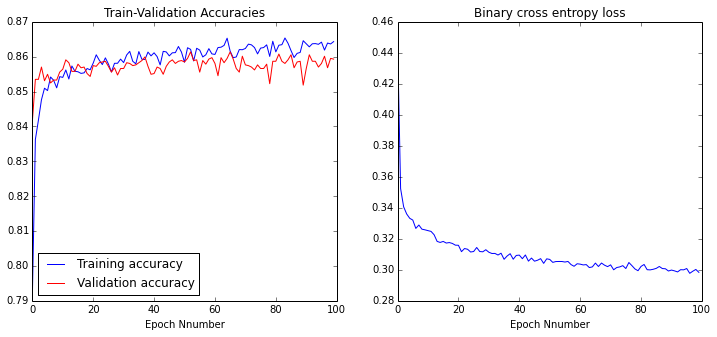

In [24]:
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(np.arange(100), train_acc, 'b', label='Training accuracy');ax[0].plot(np.arange(100), val_acc, 'r', label='Validation accuracy'); ax[0].set_title('Train-Validation Accuracies'); ax[0].legend(loc=0); ax[0].set_xlabel('Epoch Nnumber');
ax[1].plot(losses); ax[1].set_title('Binary cross entropy loss'); ax[1].set_xlabel('Epoch Nnumber');

Perfomance on the test set

In [25]:
y_pred = nn.predict_on_batch(input_list_test)

In [26]:
y_pred =y_pred.astype(int)

In [27]:
accuracy_score(y_test, y_pred)

0.7566716393170894

Save the learned model

In [28]:
model_path, weights_path = 'models/nn_basic_cv.json', 'models/nn_basic_cv_weights.h5'

In [29]:
eh.save_model(nn, model_path, weights_path)

Saved model to models/nn_basic_cv.json
Saved model weights to models/nn_basic_cv_weights.h5


Save the category embeddings

In [30]:
country_embedding = nn.get_layer('country_embedding').get_weights()[0]
education_embedding = nn.get_layer('education_embedding').get_weights()[0]
marital_status_embedding = nn.get_layer('marital_status_embedding').get_weights()[0]
occupation_embedding = nn.get_layer('occupation_embedding').get_weights()[0]
race_embedding = nn.get_layer('race_embedding').get_weights()[0]
relationship_embedding = nn.get_layer('relationship_embedding').get_weights()[0]
work_class_embedding = nn.get_layer('work_class_embedding').get_weights()[0]

with open("models/embeddings.pickle", 'wb') as f:
    pickle.dump([country_embedding, 
                 education_embedding, 
                 marital_status_embedding, 
                 occupation_embedding, 
                 race_embedding, 
                 relationship_embedding,
                 work_class_embedding
                ], f, -1)